In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import copy

/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_43650/3278846729.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
cls_weseraue_10_epochs = "blur_weseraue_results.csv"
cls_weseraue_full_training = "blur_weseraue_full_training_results.csv"
cls_weseraue_no_blur = "blur_weseraue_no_blur_results.csv"
cls_weseraue_low_blur = "blur_weseraue_low_blur_results.csv"
cls_weseraue_high_blur = "blur_weseraue_high_blur_results.csv"

cls_weseraue_small_pano_no_blur = "small_pano_weseraue_no_blur_results.csv"
cls_weseraue_small_pano_low_blur = "small_pano_weseraue_low_blur_results.csv"

In [3]:
ds_version = "weseraue"
# annotations_file = "streetSurfaceVis_v1_0.csv"
# pred_file = "effnet_surface_quality_prediction-V1_0_s_1024-20240612_111928.csv"
root_data_path = os.path.join("..", "data", ds_version)
# root_data_path = f"/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/{ds_version}"
data_path = os.path.join(root_data_path, "prediction", "analysis")
# only_validation = True
confidence_threshold = 0.9

In [15]:
df_weseraue_10_epochs = pd.read_csv(os.path.join(data_path, cls_weseraue_10_epochs))
df_weseraue_full_training = pd.read_csv(os.path.join(data_path, cls_weseraue_full_training))
df_weseraue_no_blur = pd.read_csv(os.path.join(data_path, cls_weseraue_no_blur))
df_weseraue_low_blur = pd.read_csv(os.path.join(data_path, cls_weseraue_low_blur))
df_weseraue_high_blur = pd.read_csv(os.path.join(data_path, cls_weseraue_high_blur))

df_weseraue_small_pano_no_blur = pd.read_csv(os.path.join(data_path, cls_weseraue_small_pano_no_blur))
df_weseraue_small_pano_low_blur = pd.read_csv(os.path.join(data_path, cls_weseraue_small_pano_low_blur))

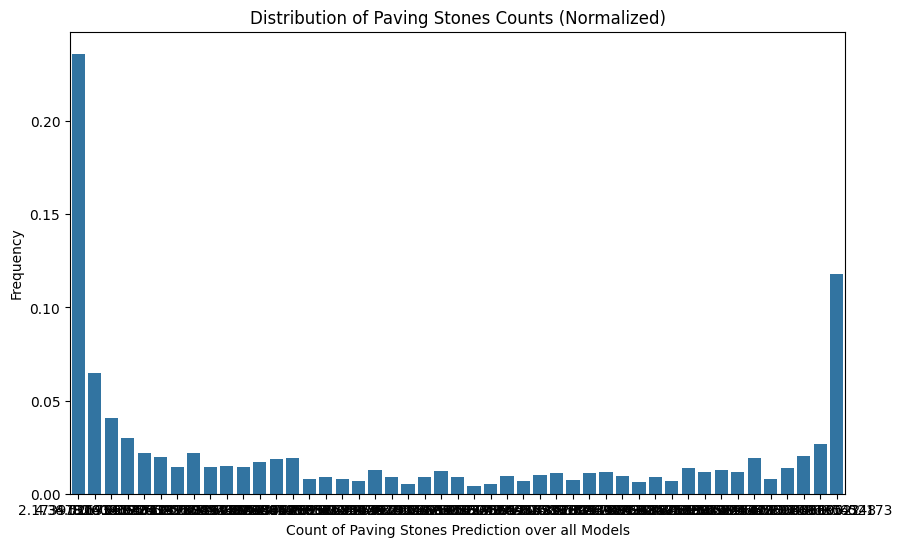

min value for Count Percentage: 0.0 (0.236215112321307), max value: 100.0 (0.11776718856364875)


In [41]:
# all with old cropping

df_list = [
    df_weseraue_10_epochs,
    df_weseraue_full_training,
    df_weseraue_no_blur,
    df_weseraue_low_blur,
    df_weseraue_high_blur,
    ]

classification = pd.DataFrame()
classification["image_id"] = df_weseraue_10_epochs["image_id"]
classification.set_index("image_id", inplace=True)

count_models_sum = 0

for i, df in enumerate(df_list):
    

    class_columns = [col for col in df.columns if 'class' in col]
    count_models_sum += len(class_columns)

    df = df.rename(columns={"paving_stones_count": f"paving_stones_count_exp_{i}"}, inplace=False)

    # classification['paving_stones_count'] = classification[class_columns].apply(lambda row: (row == 'paving_stones').sum(), axis=1)

    # classification['paving_stones_percentage'] = classification['paving_stones_count'] / len(class_columns) * 100
    classification = classification.join(df[["image_id", f"paving_stones_count_exp_{i}"]].set_index("image_id"), how="left")

count_columns = [col for col in classification.columns if 'paving_stones_count' in col]

classification['paving_stones_count_sum'] = classification[count_columns].sum(axis=1)
classification['paving_stones_percentage_sum'] = classification['paving_stones_count_sum'] / count_models_sum * 100

count_frequencies = classification['paving_stones_percentage_sum'].value_counts().sort_index()
normalized_frequencies = count_frequencies / count_frequencies.sum()

plt.figure(figsize=(10, 6))
# sns.histplot(classification['paving_stones_count'], bins=len(class_columns)+1, kde=True, stat="density")
sns.barplot(x=normalized_frequencies.index, y=normalized_frequencies.values)
plt.title('Distribution of Paving Stones Counts (Normalized)')
plt.xlabel('Count of Paving Stones Prediction over all Models')
plt.ylabel('Frequency')
# plt.xticks(ticks=[normalized_frequencies.index[0], normalized_frequencies.index[-1]], labels=[normalized_frequencies.index[0], normalized_frequencies.index[-1]])
plt.show()
print(f"min value for Count Percentage: {normalized_frequencies.index[0]} ({normalized_frequencies.values[0]}), max value: {normalized_frequencies.index[-1]} ({normalized_frequencies.values[-1]})")

classification.to_csv(os.path.join(data_path, "blur_weseraue_all_standard_pano_cropping.csv"), index=True)

In [29]:
print(classification)

                    paving_stones_count_exp_0  paving_stones_count_exp_1  \
image_id                                                                   
1003421317011254_1                          0                          0   
1004648970243129_1                          5                          5   
1005094273511271_1                          0                          0   
1006890656687898_1                         13                         13   
1007165086631803_1                          0                          0   
...                                       ...                        ...   
990912734900915_1                           0                          0   
992057481461356_1                           6                          7   
994533647929913_1                           6                          4   
997486684247204_1                           0                          0   
998677771011995_1                          13                         13   

           

In [37]:
# high blur always paving stones, low blur never paving stones
# df_high_low = pd.DataFrame()
# df_high_low["image_id"] = df_weseraue_10_epochs["image_id"]
# df_high_low.set_index("image_id", inplace=True)

# class_columns = [col for col in df_weseraue_low_blur.columns if 'class' in col]
# df_high_low["all_low_no_high"] = (df_weseraue_low_blur["paving_stones_count"] == len(class_columns) & df_weseraue_high_blur["paving_stones_count"] == 0)
# class_columns = [col for col in df_weseraue_high_blur.columns if 'class' in col]
# df_high_low["all_high_no_low"] = (df_weseraue_high_blur["paving_stones_count"] == len(class_columns) & df_weseraue_low_blur["paving_stones_count"] == 0)
class_columns = [col for col in df_weseraue_low_blur.columns if 'class' in col]
((df_weseraue_low_blur["paving_stones_count"] == len(class_columns)) & (df_weseraue_high_blur["paving_stones_count"] == 0)).sum()



9

In [38]:
class_columns = [col for col in df_weseraue_high_blur.columns if 'class' in col]
((df_weseraue_high_blur["paving_stones_count"] == len(class_columns)) & (df_weseraue_low_blur["paving_stones_count"] == 0)).sum()


1

In [21]:
# normalized_frequencies

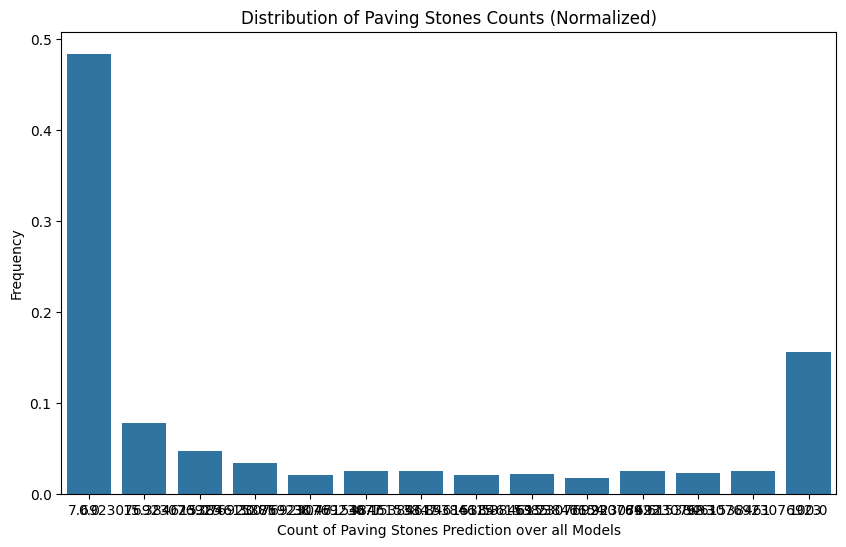

min value for Count Percentage: 0.0 (0.4833219877467665), max value: 100.0 (0.15520762423417292)


In [23]:
# no blur with old and small_pano cropping

df_list = [
    df_weseraue_no_blur,
    df_weseraue_small_pano_no_blur,
    ]

classification = pd.DataFrame()
classification["image_id"] = df_weseraue_10_epochs["image_id"]
classification.set_index("image_id", inplace=True)

count_models_sum = 0

for i, df in enumerate(df_list):
    

    class_columns = [col for col in df.columns if 'class' in col]
    count_models_sum += len(class_columns)

    df = df.rename(columns={"paving_stones_count": f"paving_stones_count_model_{i}"}, inplace=False)

    # classification['paving_stones_count'] = classification[class_columns].apply(lambda row: (row == 'paving_stones').sum(), axis=1)

    # classification['paving_stones_percentage'] = classification['paving_stones_count'] / len(class_columns) * 100
    classification = classification.join(df[["image_id", f"paving_stones_count_model_{i}"]].set_index("image_id"), how="left")

count_columns = [col for col in classification.columns if 'paving_stones_count' in col]

classification['paving_stones_count_sum'] = classification[count_columns].sum(axis=1)
classification['paving_stones_percentag_sume'] = classification['paving_stones_count_sum'] / count_models_sum * 100

count_frequencies = classification['paving_stones_percentag_sume'].value_counts().sort_index()
normalized_frequencies = count_frequencies / count_frequencies.sum()

plt.figure(figsize=(10, 6))
# sns.histplot(classification['paving_stones_count'], bins=len(class_columns)+1, kde=True, stat="density")
sns.barplot(x=normalized_frequencies.index, y=normalized_frequencies.values)
plt.title('Distribution of Paving Stones Counts (Normalized)')
plt.xlabel('Count of Paving Stones Prediction over all Models')
plt.ylabel('Frequency')
# plt.xticks(ticks=[normalized_frequencies.index[0], normalized_frequencies.index[-1]], labels=[normalized_frequencies.index[0], normalized_frequencies.index[-1]])
plt.show()
print(f"min value for Count Percentage: {normalized_frequencies.index[0]} ({normalized_frequencies.values[0]}), max value: {normalized_frequencies.index[-1]} ({normalized_frequencies.values[-1]})")


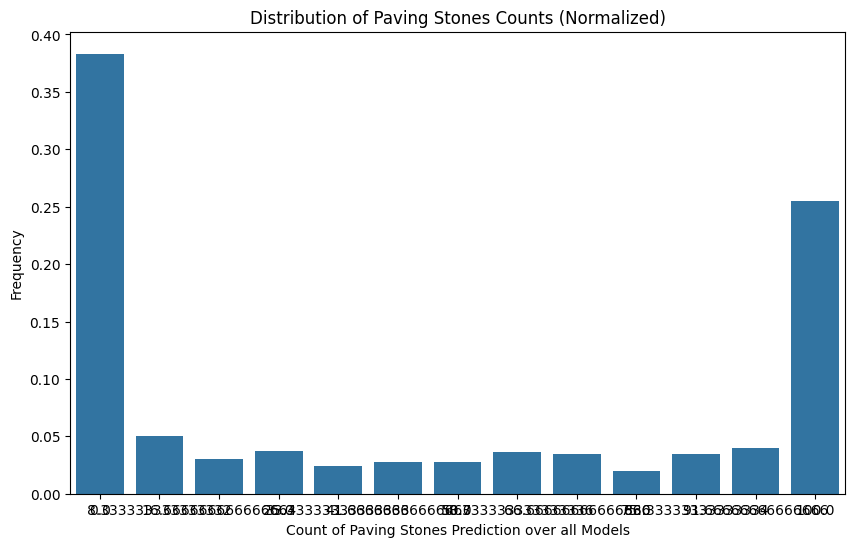

min value for Count Percentage: 0.0 (0.38325391422736554), max value: 100.0 (0.2545949625595643)


In [24]:
# no blur with old and small_pano cropping

df_list = [
    df_weseraue_low_blur,
    df_weseraue_small_pano_low_blur,
    ]

classification = pd.DataFrame()
classification["image_id"] = df_weseraue_10_epochs["image_id"]
classification.set_index("image_id", inplace=True)

count_models_sum = 0

for i, df in enumerate(df_list):
    

    class_columns = [col for col in df.columns if 'class' in col]
    count_models_sum += len(class_columns)

    df = df.rename(columns={"paving_stones_count": f"paving_stones_count_model_{i}"}, inplace=False)

    # classification['paving_stones_count'] = classification[class_columns].apply(lambda row: (row == 'paving_stones').sum(), axis=1)

    # classification['paving_stones_percentage'] = classification['paving_stones_count'] / len(class_columns) * 100
    classification = classification.join(df[["image_id", f"paving_stones_count_model_{i}"]].set_index("image_id"), how="left")

count_columns = [col for col in classification.columns if 'paving_stones_count' in col]

classification['paving_stones_count_sum'] = classification[count_columns].sum(axis=1)
classification['paving_stones_percentag_sume'] = classification['paving_stones_count_sum'] / count_models_sum * 100

count_frequencies = classification['paving_stones_percentag_sume'].value_counts().sort_index()
normalized_frequencies = count_frequencies / count_frequencies.sum()

plt.figure(figsize=(10, 6))
# sns.histplot(classification['paving_stones_count'], bins=len(class_columns)+1, kde=True, stat="density")
sns.barplot(x=normalized_frequencies.index, y=normalized_frequencies.values)
plt.title('Distribution of Paving Stones Counts (Normalized)')
plt.xlabel('Count of Paving Stones Prediction over all Models')
plt.ylabel('Frequency')
# plt.xticks(ticks=[normalized_frequencies.index[0], normalized_frequencies.index[-1]], labels=[normalized_frequencies.index[0], normalized_frequencies.index[-1]])
plt.show()
print(f"min value for Count Percentage: {normalized_frequencies.index[0]} ({normalized_frequencies.values[0]}), max value: {normalized_frequencies.index[-1]} ({normalized_frequencies.values[-1]})")
